# Binary Classification: Classifying 0s and 5s from MNIST dataset

This notebook is following the theory present [here](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb), provided by: *fastai*

You can also read the full documentation, [here](https://docs.fast.ai/)

## Imports

In [1]:
!pip install -Uqq --user fastbook
!pip install --user graphviz

In [2]:
import pandas as pd
import fastbook
from fastai.vision.all import *
from fastbook import *

In [3]:
from fastai.vision import *

In [4]:
import matplotlib.pyplot as plt

In [5]:
fastbook.setup_book()

## Setting up data

### Getting MNIST dataset

This cell will get the role MNIST dataset (i.e. all the digits included).

In [6]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
path.ls() # this line allow you to visualize the folders in the dataset

(#2) [Path('testing'),Path('training')]

But, for this task, we only want 0s and 5s digits. So, it is possible to "select" them specifying the correct path.

In [7]:
# Training data
t_zeros = (path/"training"/"0").ls().sorted()
t_fives = (path/"training"/"5").ls().sorted()

# Testing data
v_zeros = (path/"testing"/"0").ls()
v_fives = (path/"testing"/"5").ls()

### Data visualization

Visualizing a sample of digit 5 from training data

In [8]:
im5_path = t_fives[1]
im5 = Image.open(im5_path)
im5

It is also possible to visualize the values of the pixels of image and color them setting dataframe style.

In [9]:
im5_t = tensor(im5)
df = pd.DataFrame(im5_t[:,:])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,2,18,46,136,136,244,255,241,103,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,15,94,163,253,253,253,253,238,218,204,35,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,131,253,253,253,253,237,200,57,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,155,246,253,247,108,65,45,0,0,0,0,0,0,0,0,0,0,0


### Data transforming and normalization

The next step is to convert all the images, train and val, to a respective **Pytorch Tensor**.

In [10]:
train_zeros = [tensor(Image.open(o)) for o in t_zeros]
train_fives = [tensor(Image.open(o)) for o in t_fives]


test_zeros = [tensor(Image.open(o)) for o in v_zeros]
test_fives = [tensor(Image.open(o)) for o in v_fives]

print(f'-------- Training data \n0s: {len(train_zeros)}, 5s: {len(train_fives)}\n')
print(f'-------- Validation data \n0s: {len(test_zeros)}, 5s: {len(test_fives)}')

-------- Training data 
0s: 5923, 5s: 5421

-------- Validation data 
0s: 980, 5s: 892


Data normalization is also necessary to make the computation much easier, instead of having the images with pixels between [0, 255], we can normalizate the pixels to be between [0,1].

In [11]:
stacked_train_zeros = torch.stack(train_zeros).float()/255
stacked_train_fives = torch.stack(train_fives).float()/255

stacked_test_zeros = torch.stack(test_zeros).float()/255
stacked_test_fives = torch.stack(test_fives).float()/255

print(f'Shape of training data \n0s: {stacked_train_zeros.shape}, 5s: {stacked_train_fives.shape}\n')
print(f'Shape of validation data \n0s: {stacked_test_zeros.shape}, 5s: {stacked_test_fives.shape}')

Shape of training data 
0s: torch.Size([5923, 28, 28]), 5s: torch.Size([5421, 28, 28])

Shape of validation data 
0s: torch.Size([980, 28, 28]), 5s: torch.Size([892, 28, 28])


The shape of data is composed by 3 indexes [number of images, width, height]. The first one ([0]) is the amount of images, the index 2 ([1]) and 3 ([2]) are the dimensions of each image, which is 28 x 28.

### Concatenating data

We need a single tensor, containing the 0s and 5s digits, to use for training. Function `torch.cat` can do this by concatenating the 0s and 5s digits in a single tensor.
The variable `train_x` is composed by all the 0s and 5s digits, but we need the labels for them. So we will use the label **1** for 0s and label **0** for 5s and save this labels in `train_y`.

In [12]:
train_x = torch.cat([stacked_train_zeros, stacked_train_fives]).view(-1, 28*28)
train_y = tensor([1]*len(t_zeros) + [0]*len(t_fives)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([11344, 784]), torch.Size([11344, 1]))

To training a model in Pytorch, it is necessary to use the dataset as tuple `(x,y)` containing the data and the labels. It is possible to create this by ziping `train_x` and `train_y` together.

In [13]:
train_dataset = list(zip(train_x,train_y))
x,y = train_dataset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

And repeat the previous two steps for testing data

In [14]:
test_x = torch.cat([stacked_test_zeros, stacked_test_fives]).view(-1, 28*28)
test_y = tensor([1]*len(test_zeros) + [0]*len(test_fives)).unsqueeze(1)
test_dataset = list(zip(test_x,test_y))

## Defining loss function and metrics

### Loss function

Loss function that measures the distance between predictions and targets, applying sigmoid function to the inputs.

The sigmoid function is used return values between 0 and 1, since our labels are 0 and 1. 

**The prediction, the closer to 1, the more likely it is to look like the image with label 1 (digit 0). And closer to 0, the more likely it is to look like the image with label 0 (digit 5)**

In [15]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### Validation accuracy

This function is used as metric for our model, we can see if the model is perfoming well if it has a high accuracy on unseen data (validation data).

In [16]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

## Model

Our model is composed by two liner layers and ReLU as activation function.

In [17]:
net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

The `DataLoader` is used to transform the dataset to a iterator, so it can be iterated over the mini-batches. Mini-batch is a few data items from the role dataset. The number of data items in the mini-batch is called *batch_size*.

In [18]:
train_dl = DataLoader(train_dataset, batch_size=256)
test_dl = DataLoader(test_dataset, batch_size=256)

xb,yb = first(train_dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

As we going to use ``Leaner.fit`` method, we need to create a ``DataLoaders`` containing our training and testing data.

In [19]:
data_loaders = DataLoaders(train_dl, test_dl)

### Creating Learner

The ``Leaner``, provided by fastai, is a class that handle the training phase by grouping together ``model``, ``dls``, ``loss_func`` and ``metrics``.

(Read ``Leaner`` [docs](https://docs.fast.ai/learner.html#Learner))

In [20]:
learn = Learner(data_loaders, net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

## Training

To train the ``model``, we can use the ``Learner.fit`` method passing as arguments the **number of epochs** and the **learning rate**.

In [21]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.362468,0.499550,0.476496,00:00
1,0.221375,0.450504,0.494124,00:00
2,0.137797,0.315581,0.686432,00:00
3,0.088968,0.205213,0.827457,00:00
4,0.062394,0.139661,0.898504,00:00
5,0.047733,0.101666,0.930021,00:00
6,0.039267,0.078775,0.946581,00:00
7,0.034105,0.063978,0.958333,00:00
8,0.030766,0.053868,0.965278,00:00
9,0.028474,0.046649,0.967949,00:00


## Results

This section will show the results of the training realized in the previous section. 
It also show if the model perfomed well and if it can classify correctly the digit 0 and digit 5.

### Accuracy

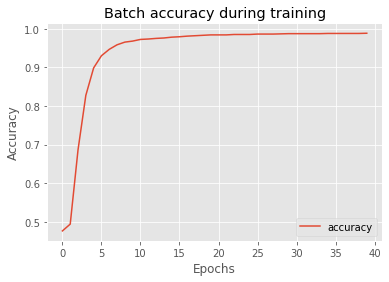

In [22]:
plt.style.use('ggplot')
plt.plot(L(learn.recorder.values).itemgot(2));
plt.title('Batch accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy'])
plt.show()

This plot shows how accuracy improves over the training

### Losses

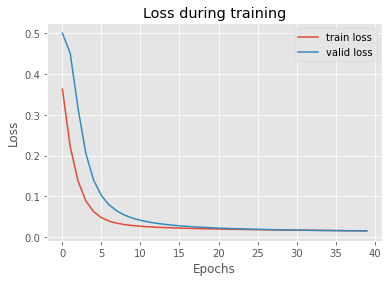

In [23]:
plt.style.use('ggplot')
plt.plot(L(learn.recorder.values).itemgot(0));
plt.plot(L(learn.recorder.values).itemgot(1));
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train loss', 'valid loss'])
plt.show()

This plot shows how loss converge over the training

#### Final Accuracy

In [24]:
learn.recorder.values[-1][2]

0.9882478713989258

## Saving model

In [25]:
learn.save('model')

Path('models/model.pth')